In [54]:
# for data manipulation
import pandas as pd
import numpy as np

# plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#models to run
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import LabelBinarizer

# train_test split
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score

#save model to file
from sklearn.externals import joblib

#metrics
from sklearn.metrics import confusion_matrix,accuracy_score,precision_recall_fscore_support 


### Objective of sprint 1:
1. Read csv file.
2. Look at the shape of dataframe.
3. Clean label.
4. Check for duplicates and remove duplicates.
5. A bar plot of distribution of labels, i.e. attack-types using ```sns.countplot```
6. Convert labels into attack_types.
    1. ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop'] -> 'dos'
    2. ['buffer_overflow', 'loadmodule','perl', 'rootkit'] -> 'utr'
    3. ['Ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy','warezclient', 'warezmaster'] -> 'rtl'
    4. ['satan', 'ipsweep', 'nmap', 'portsweep'] -> 'probes'
7. A bar plot of distribution of attack-type labels (normal, dos, utr, rtl, probes)
8. Distribution of features
    1. Categorical features : Use ```sns.countplot``` to understand prominent values of a feature in each class.
    2. Continuous features : Use ```sns.boxplot``` to understand distribution of a feature in each class.

In [55]:
# read raw data
raw_data = pd.read_csv('../../../session_1_data_train.csv')

In [56]:
test_data = pd.read_csv('../../../session_1_data_test.csv')
test_data.columns = raw_data.columns

In [57]:
raw_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [58]:
raw_data.label.value_counts().keys()

Index([u'smurf.', u'neptune.', u'normal.', u'back.', u'satan.', u'ipsweep.',
       u'portsweep.', u'warezclient.', u'teardrop.', u'pod.', u'nmap.',
       u'guess_passwd.', u'buffer_overflow.', u'land.', u'warezmaster.',
       u'imap.', u'rootkit.', u'loadmodule.', u'ftp_write.', u'multihop.',
       u'phf.', u'perl.', u'spy.'],
      dtype='object')

In [59]:
test_data.label.value_counts().keys()

Index([u'smurf.', u'normal.', u'neptune.', u'snmpgetattack.', u'mailbomb.',
       u'guess_passwd.', u'snmpguess.', u'satan.', u'warezmaster.', u'back.',
       u'mscan.', u'apache2.', u'processtable.', u'saint.', u'portsweep.',
       u'ipsweep.', u'httptunnel.', u'pod.', u'nmap.', u'buffer_overflow.',
       u'multihop.', u'named.', u'sendmail.', u'ps.', u'xterm.', u'rootkit.',
       u'teardrop.', u'xlock.', u'land.', u'xsnoop.', u'ftp_write.',
       u'sqlattack.', u'loadmodule.', u'worm.', u'perl.', u'phf.',
       u'udpstorm.', u'imap.'],
      dtype='object')

In [60]:
# remove ". " from labels
raw_data['label'] = raw_data['label'].apply(lambda x: x[:-1])
test_data['label'] = test_data['label'].apply(lambda x: x[:-1])

In [61]:
# drop duplicate records
raw_data.drop_duplicates(inplace = True)
test_data.drop_duplicates(inplace = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

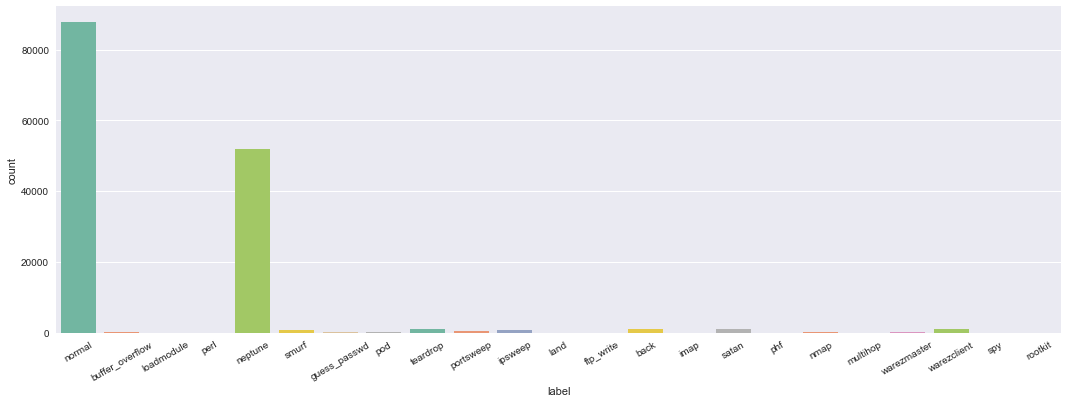

In [62]:
# distribution of labels

sns.set_color_codes()

fig, ax1 = plt.subplots(1,1, figsize = (18,6))

sns.countplot('label', data = raw_data,palette="Set2", ax = ax1)
plt.xticks(rotation=30)

In [63]:
# combining labels as normal, denial of Service, user to root, remote to local, probes

def label_grouping(label):
    if label in ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']: 
        return 'dos'
    elif label in ['buffer_overflow', 'loadmodule','perl', 'rootkit']:
        return 'utr'
    elif label in ['Ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy','warezclient', 'warezmaster']:
        return 'rtl'
    elif label in ['satan', 'ipsweep', 'nmap', 'portsweep']:
        return 'probes'
    elif label=='normal':
        return 'normal'
    else:
        return 'others'

raw_data['label_attack_type']= raw_data['label'].apply(label_grouping)
test_data['label_attack_type']= test_data['label'].apply(label_grouping)

In [64]:
raw_data['label_attack_type'].value_counts()

normal    87831
dos       54572
probes     2131
rtl         991
utr          52
others        8
Name: label_attack_type, dtype: int64

In [65]:
test_data['label_attack_type'].value_counts()

normal    47913
dos       21720
others     4025
rtl        2325
probes     1269
utr          39
Name: label_attack_type, dtype: int64

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

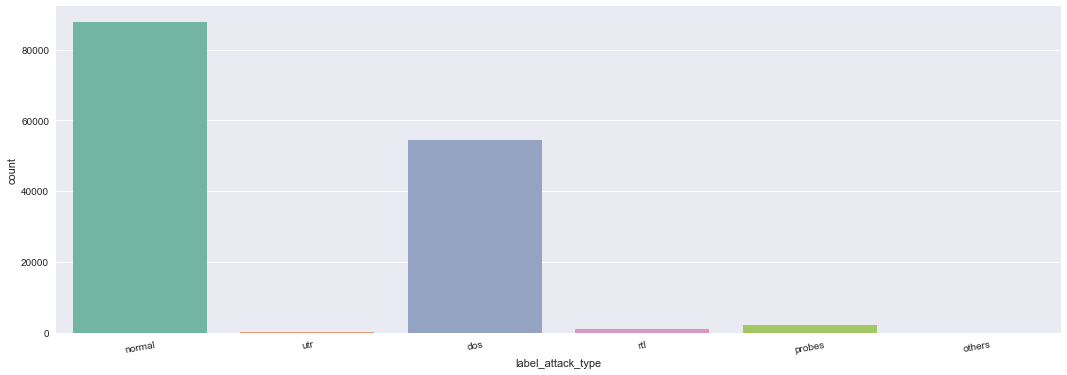

In [66]:
# distribution of label_attack_type

fig, ax1 = plt.subplots(1,1, figsize = (18,6))

sns.countplot('label_attack_type', data = raw_data,palette="Set2", ax = ax1)
plt.xticks(rotation=10)

In [67]:
raw_data.columns

Index([u'duration', u'protocol_type', u'service', u'flag', u'src_bytes',
       u'dst_bytes', u'land', u'wrong_fragment', u'urgent', u'hot',
       u'num_failed_logins', u'logged_in', u'num_compromised', u'root_shell',
       u'su_attempted', u'num_root', u'num_file_creations', u'num_shells',
       u'num_access_files', u'num_outbound_cmds', u'is_host_login',
       u'is_guest_login', u'count', u'srv_count', u'serror_rate',
       u'srv_serror_rate', u'rerror_rate', u'srv_rerror_rate',
       u'same_srv_rate', u'diff_srv_rate', u'srv_diff_host_rate',
       u'dst_host_count', u'dst_host_srv_count', u'dst_host_same_srv_rate',
       u'dst_host_diff_srv_rate', u'dst_host_same_src_port_rate',
       u'dst_host_srv_diff_host_rate', u'dst_host_serror_rate',
       u'dst_host_srv_serror_rate', u'dst_host_rerror_rate',
       u'dst_host_srv_rerror_rate', u'label', u'label_attack_type'],
      dtype='object')

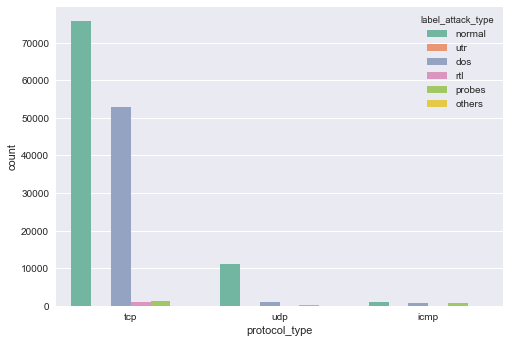

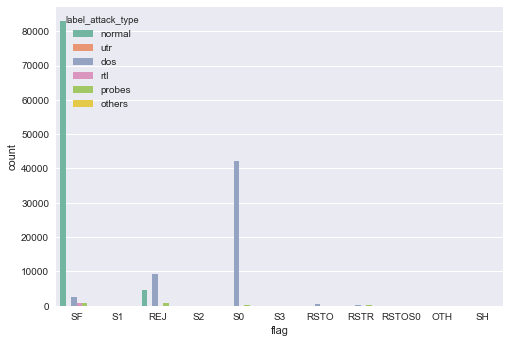

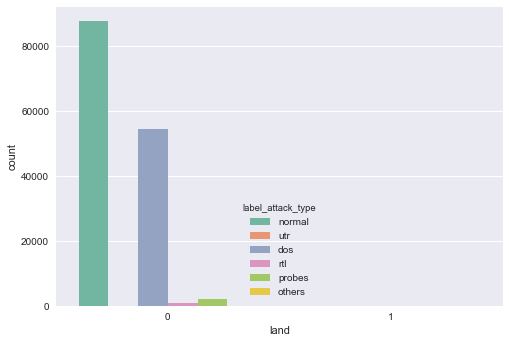

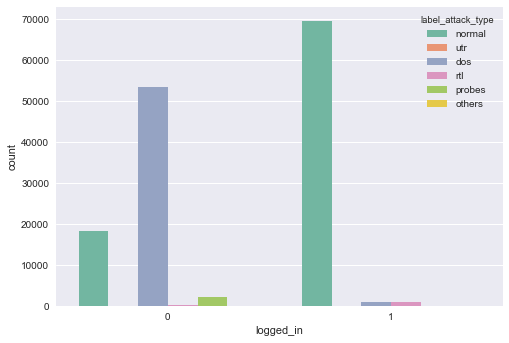

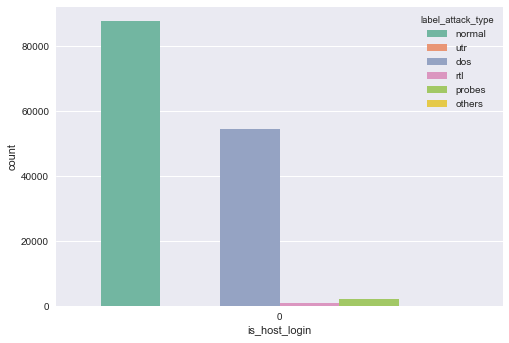

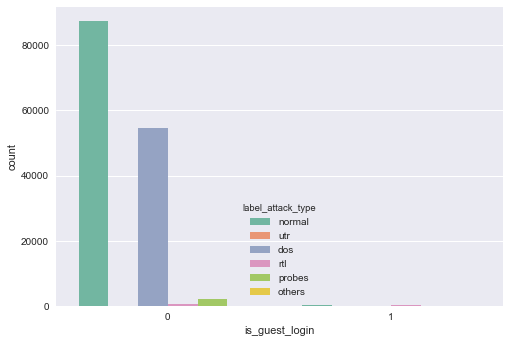

In [68]:
# distribution of categorical variables with 'label_attack_type'
sns.set()
categorical_cols = ['protocol_type','flag','land','logged_in','is_host_login','is_guest_login']

for col in categorical_cols:
    plt.figure()
    sns.countplot(x=col, hue="label_attack_type",data=raw_data, palette="Set2")

### Objective of sprint 2 (~30 minutes):
1. Convert data labels to numerical values. {dos=1,utr=2,rtl=3,probes=4,normal=0}
3. One-hot encoding of categorical features i.e. flag and protocol_type.
4. Stratified sampling. Use ```train_test_split```. Keep a 70-30 split in training-testing data split.
5. Write evaluation function to calculate accuracy, precision, recall, roc_auc_curve, confusion matrix. Call it ```get_performance_metrics(y_test, model_predictions)```
6. Fit different models and calculate performance metrics.
    1. Use Naive Bayes, Logistic Regression.
    2. Use Decision Tree.

In [69]:
def get_label_encoding(label):
    if label == 'dos':
        return 1
    elif label == 'utr':
        return 2
    elif label == 'rtl':
        return 3
    elif label == 'probes':
        return 4
    elif label == 'others':
        return 5
    else:
        return 0

raw_data['label_encoding']= raw_data['label_attack_type'].apply(get_label_encoding)
test_data['label_encoding']= test_data['label_attack_type'].apply(get_label_encoding)
raw_data['label_encoding'].value_counts()

0    87831
1    54572
4     2131
3      991
2       52
5        8
Name: label_encoding, dtype: int64

In [70]:
#one hot encoding of categorical variables
flag_encoding_test = pd.get_dummies(test_data['flag'],prefix = 'flag')
protocol_encoding_test = pd.get_dummies(test_data['protocol_type'],prefix = 'protocol')

# concat with original dataframe
test_data = pd.concat([test_data, flag_encoding_test,protocol_encoding_test],axis =1)

In [71]:
#one hot encoding of categorical variables
flag_encoding_raw = pd.get_dummies(raw_data['flag'],prefix = 'flag')
protocol_encoding_raw = pd.get_dummies(raw_data['protocol_type'],prefix = 'protocol')

# concat with original dataframe
raw_data = pd.concat([raw_data, flag_encoding_raw,protocol_encoding_raw],axis =1)

In [72]:
raw_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,protocol_icmp,protocol_tcp,protocol_udp
0,0,tcp,http,SF,181,5450,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0,tcp,http,SF,239,486,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### Train test split

In [73]:

predictors = [c for c in raw_data.columns if c not in ['label', 'label_attack_type', 'index', 'protocol_type',
                                                   'flag','service','is_host_login','label_encoding',
                                                    'count','same_srv_rate','diff_srv_rate','src_bytes','flag_SF',
                                                      'dst_host_same_srv_rate','dst_host_srv_count',
                                                       'dst_bytes','dst_host_srv_serror_rate',
                                                       'dst_host_diff_srv_rate','dst_host_serror_rate'
                                                      'srv_serror_rate','flag_S0','serror_rate','logged_in',
                                                       'dst_host_same_src_port_rate','dst_host_count']]

X_train = raw_data[predictors]
y_train = raw_data['label_encoding']
X_test = test_data[predictors]
y_test = test_data['label_encoding']

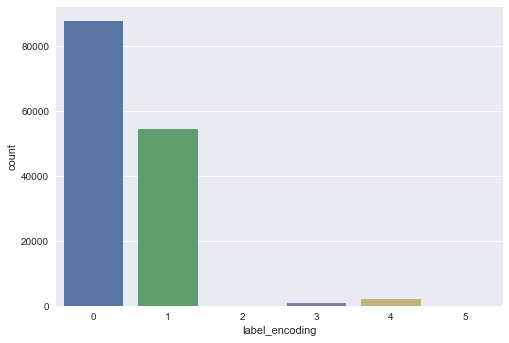

In [75]:
sns.countplot(y_train)

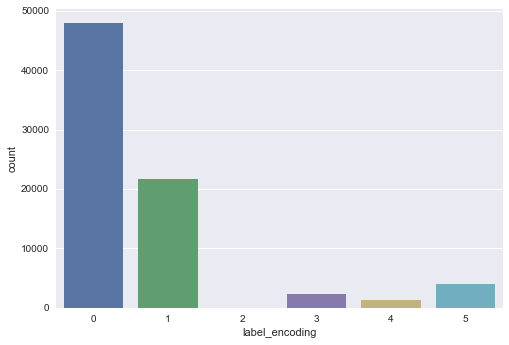

In [22]:
sns.countplot(y_test)

##### Evaluation function   
Metrics - Accuracy, precision, recall, F1 score, Confusion matrix, roc_auc 

In [82]:
def get_performance_metrics(y_test,model_predictions):
    # Accuracy
    model_accuracy = accuracy_score(y_test,model_predictions)
    print("Accuracy is ", model_accuracy)

    # precision, recall, f1 score
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_test,model_predictions)
    print('Precision for each class is ', model_precision)
    print('Recall/sensitivity for each class is ', model_recall)
    print('F1 Score for each class is ', model_f1)

    # confusion matrix
    model_confusion_matrix = confusion_matrix(y_test,model_predictions)
    print('confusion matrix is :-->')
    print(model_confusion_matrix)

### Decision Tree

In [24]:
#create instance of decision tree
dt_model = DecisionTreeClassifier(random_state = 3)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best')

In [25]:
#making predictions
dt_predictions = dt_model.predict(X_test)

In [26]:
get_performance_metrics(y_test,dt_predictions)

('Accuracy is ', 0.89597753942891156)
('Precision for each class is ', array([ 0.90680662,  0.98593973,  0.4516129 ,  0.63287402,  0.27464789,  1.        ]))
('Recall/sensitivity for each class is ', array([  9.93488197e-01,   9.23342541e-01,   3.58974359e-01,
         2.76559140e-01,   7.37588652e-01,   4.96894410e-04]))
('F1 Score for each class is ', array([ 0.94817043,  0.95361499,  0.4       ,  0.3849147 ,  0.40025657,
        0.0009933 ]))
confusion matrix is :-->
[[47601    63     8    86   155     0]
 [  228 20055     0    16  1421     0]
 [   17     0    14     8     0     0]
 [ 1587     0     2   643    93     0]
 [  308    25     0     0   936     0]
 [ 2752   198     7   263   803     2]]


### Support Vector Machine

In [27]:
svc_model = SVC()

In [ ]:
svc_model.fit(X_train,y_train)

In [ ]:
svc_predictions = svc_model.predict(X_test)
get_performance_metrics(y_test,svc_predictions)

### Objective of sprint 3 (~30 minutes):
1. Write code for Stratified K-Fold Cross Validation (Decision Tree)
2. Fit a random forest model.
3. Add class weights to random forest model.

### Using Straified K-Fold Cross Validation (Decision Tree)

maintaining percentage of samples for each class

In [28]:
dt_model = DecisionTreeClassifier(random_state = 3)
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 2)
predictions = []
score = []

for i, (train_index,test_index) in enumerate(skf.split(X_train,y_train)):

    train_predictors = X_train.iloc[train_index]
    train_target = y_train.iloc[train_index]
    
    test_predictors = X_train.iloc[test_index]
    test_target = y_train.iloc[test_index]
    
    #fit the model
    dt_model.fit(train_predictors,train_target)
    
    #make predictions
    test_pred = dt_model.predict(test_predictors)
   
    accuracy = accuracy_score(test_target, test_pred)
    score.append(accuracy)
    
    p, r, f1, support = precision_recall_fscore_support(test_target, test_pred)
    confusion = confusion_matrix(test_target, test_pred)
    
    print('------------------------------')
    print('Accuracy at {0}-Fold is'.format(i),accuracy)
    print('Precision at {0}-Fold is'.format(i), p)
    print('Recall at {0}-Fold is'.format(i), r)
    print('F1 score at {0}-Fold is'.format(i), f1)
    print('Confusion matrix at {0}-Fold is :-->'.format(i))
    print(confusion)
    print('------------------------------')
    
#calculating average accuracy , precision, recall, F1 score   
print('Average accuracy is', np.mean(score))



------------------------------
('Accuracy at 0-Fold is', 0.99390080567060235)
('Precision at 0-Fold is', array([ 0.9939041 ,  0.99741943,  0.7       ,  0.84507042,  0.96509863,  1.        ]))
('Recall at 0-Fold is', array([ 0.9968576 ,  0.99862569,  0.38888889,  0.72507553,  0.89451477,
        0.33333333]))
('F1 score at 0-Fold is', array([ 0.99537866,  0.9980222 ,  0.5       ,  0.7804878 ,  0.92846715,
        0.5       ]))
Confusion matrix at 0-Fold is :-->
[[29185    29     0    43    20     0]
 [   23 18166     0     0     2     0]
 [   10     0     7     0     1     0]
 [   86     2     3   240     0     0]
 [   58    16     0     1   636     0]
 [    2     0     0     0     0     1]]
------------------------------


/Users/sourabhrohilla/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


------------------------------
('Accuracy at 1-Fold is', 0.9945186284207056)
('Precision at 1-Fold is', array([ 0.99481689,  0.99802404,  0.64285714,  0.84262295,  0.9623494 ,  0.        ]))
('Recall at 1-Fold is', array([ 0.99648188,  0.99956022,  0.52941176,  0.77878788,  0.9       ,  0.        ]))
('F1 score at 1-Fold is', array([ 0.99564869,  0.99879154,  0.58064516,  0.80944882,  0.930131  ,  0.        ]))
Confusion matrix at 1-Fold is :-->
[[29174    31     4    44    24     0]
 [    4 18183     0     3     1     0]
 [    7     0     9     1     0     0]
 [   70     2     1   257     0     0]
 [   68     3     0     0   639     0]
 [    3     0     0     0     0     0]]
------------------------------
------------------------------
('Accuracy at 2-Fold is', 0.99379713967769856)
('Precision at 2-Fold is', array([ 0.99406973,  0.997531  ,  0.52631579,  0.83846154,  0.95575221,
        0.5       ]))
('Recall at 2-Fold is', array([ 0.99624278,  0.99950522,  0.58823529,  0.66060606,  0

### Random Forest Model

In [29]:
rf_model = RandomForestClassifier(n_estimators=1000,n_jobs = -1, random_state=3)

In [30]:
# fitting data to random forest model
rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

In [46]:
# predictions
rf_predictions = rf_model.predict(X_test)

In [47]:
get_performance_metrics(y_test,rf_predictions)

('Accuracy is ', 0.98167155425219943)
('Precision for each class is ', array([ 0.98635072,  0.99693157,  0.53846154,  0.94887218,  0.878125  ,
        0.89588378]))
('Recall/sensitivity for each class is ', array([ 0.99039933,  0.99723757,  0.58333333,  0.90530846,  0.73753281,
        0.91887417]))
('F1 Score for each class is ', array([ 0.98837088,  0.99708455,  0.56      ,  0.92657856,  0.80171184,
        0.90723335]))
confusion matrix is :-->
[[14236     9     2    31     8    88]
 [    6  6498     0     0     8     4]
 [    2     0     7     0     0     3]
 [   59     0     2   631     0     5]
 [   62     9     0     0   281    29]
 [   68     2     2     3    23  1110]]


### One vs Rest Classifier

The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes.

In [64]:
ovr_dt_model = OneVsRestClassifier(DecisionTreeClassifier(random_state = 3))
ovr_dt_model.fit(X_train, y_train)

OneVsRestClassifier(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
          n_jobs=1)

In [65]:
#making predictions
ovr_dt_predictions = ovr_dt_model.predict(X_test)

In [66]:
get_performance_metrics(y_test,ovr_dt_predictions)

('Accuracy is ', 0.99890099825991396)
('Precision for each class is ', array([ 0.99950651,  0.99993891,  0.69230769,  0.98630137,  0.96060606]))
('Recall/sensitivity for each class is ', array([ 0.99916515,  0.9996946 ,  0.5625    ,  0.96969697,  0.99217527]))
('F1 Score for each class is ', array([ 0.9993358 ,  0.99981674,  0.62068966,  0.97792869,  0.97613549]))
confusion matrix is :-->
[[26330     1     3     2    16]
 [    2 16367     0     0     3]
 [    2     0     9     2     3]
 [    4     0     1   288     4]
 [    5     0     0     0   634]]


### One vs One Classifier

This strategy consists in fitting one classifier per class pair. At prediction time, the class which received the most votes is selected. 

In [80]:
ovo_dt_model = OneVsOneClassifier(DecisionTreeClassifier(random_state = 3))
ovo_dt_model.fit(X_train, y_train)

OneVsOneClassifier(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=3,
            splitter='best'),
          n_jobs=1)

In [81]:
#making predictions
ovo_dt_predictions = ovo_dt_model.predict(X_test)

In [82]:
get_performance_metrics(y_test,ovo_dt_predictions)

('Accuracy is ', 0.9938181152120158)
('Precision for each class is ', array([ 0.99401878,  0.99780421,  0.63636364,  0.79496403,  0.97395833]))
('Recall/sensitivity for each class is ', array([ 0.99643291,  0.99920596,  0.4375    ,  0.74410774,  0.87793427]))
('F1 Score for each class is ', array([ 0.99522438,  0.99850459,  0.51851852,  0.76869565,  0.92345679]))
confusion matrix is :-->
[[26258    28     2    52    12]
 [   10 16359     0     1     2]
 [    7     0     7     2     0]
 [   73     0     2   221     1]
 [   68     8     0     2   561]]


### Addressing imbalance data at the algorithm level, or after it:

#### 1. Adjust the class weight (misclassification costs) for Random Forest

In [90]:
y_train_columns = pd.get_dummies(y_train,prefix = 'label')

In [91]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3, stratify = y)
Cost_weights = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 100}, {0: 1, 1: 50},{0: 1, 1: 10},{0: 1, 1: 10}]

rf_model = RandomForestClassifier(n_estimators=100,n_jobs = -1, random_state=3, class_weight=Cost_weights)
# fitting data to random forest model
rf_model.fit(X_train,y_train_columns)

# predictions
rf_predictions_df = pd.DataFrame(rf_model.predict(X_test))
rf_predictions_df.head()

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


In [92]:
rf_predictions_df['predict'] =  rf_predictions_df.apply(
                        lambda row: row[0]*0 + row[1]*1+row[2]*2 + row[3]*3 + row[4]*4 , axis=1)
rf_predictions=rf_predictions_df['predict']
get_performance_metrics(y_test,rf_predictions)

('Accuracy is ', 0.91380626463624481)
('Precision for each class is ', array([ 0.89110318,  0.98739247,  0.        ,  0.90909091,  0.69404631,  0.        ]))
('Recall/sensitivity for each class is ', array([ 0.99484482,  0.99880295,  0.        ,  0.00430108,  0.99211978,  0.        ]))
('F1 Score for each class is ', array([ 0.94012071,  0.99306493,  0.        ,  0.00856164,  0.81673694,  0.        ]))


/Users/sourabhrohilla/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


confusion matrix is :-->
[[47666    59     1     1   186     0]
 [   23 21694     0     0     3     0]
 [   39     0     0     0     0     0]
 [ 2315     0     0    10     0     0]
 [    9     1     0     0  1259     0]
 [ 3439   217     3     0   366     0]]


### Build a classifier for predicting UTR attacks.

1. Build a classifier to distinguish between UTR and non-UTR attacks. UTR is label 2.
2. Use SMOTE to tackle high class imbalance.

In [114]:
y_train_utr = y_train.copy(deep=True)
y_train_utr[y_train_utr!=2] = 0
y_train_utr[y_train_utr==2] = 1


y_test_utr = y_test.copy(deep=True)
y_test_utr[y_test_utr!=2] = 0
y_test_utr[y_test_utr==2] = 1

In [115]:
rf_model_utr = RandomForestClassifier(n_estimators=1000,n_jobs = -1, random_state=3)
rf_model_utr.fit(X_train,y_train_utr)
rf_predictions = rf_model_utr.predict(X_test)
get_performance_metrics(y_test_utr,rf_predictions)

('Accuracy is ', 0.99946953720355536)
('Precision for each class is ', array([ 0.99971523,  0.47222222]))
('Recall/sensitivity for each class is ', array([ 0.99975405,  0.43589744]))
('F1 Score for each class is ', array([ 0.99973464,  0.45333333]))
confusion matrix is :-->
[[77233    19]
 [   22    17]]


In [116]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train_utr_smote,y_train_utr_smote = sm.fit_sample(X_train,y_train_utr)

In [117]:
rf_model_utr_smote = RandomForestClassifier(n_estimators=1000,n_jobs = -1, random_state=3)
rf_model_utr_smote.fit(X_train_utr_smote,y_train_utr_smote)
rf_predictions = rf_model_utr_smote.predict(X_test)
get_performance_metrics(y_test_utr,rf_predictions)

('Accuracy is ', 0.99937897038465018)
('Precision for each class is ', array([ 0.99967639,  0.37837838]))
('Recall/sensitivity for each class is ', array([ 0.99970227,  0.35897436]))
('F1 Score for each class is ', array([ 0.99968933,  0.36842105]))
confusion matrix is :-->
[[77229    23]
 [   25    14]]
